## Clustering via $k$-means
We previously studied the classification problem using the logistic regression algorithm. Since we had labels for each data point, we may regard the problem as one of <i>supervised learning</i>. However, in many applications, the data have no labels but we wish to discover possible labels (or other hidden patterns or structures). This problem is one of <i>unsupervised learning</i>. How can we approach such problems?

<b>Clustering</b> is one class of unsupervised learning methods. In this lab, we'll consider the following form of the clustering task. Suppose you are given

a set of observations, $X≡{\{x̂_{i} | 0≤i<n\}}$, and<br>
a target number of $clusters, k$.

Your goal is to partition the points into $k$ subsets, $C_{0},…,C_{k−1} ⊆X$, which are 

- disjoint, i.e., $i≠j⟹Ci∩Cj=∅$;
- but also complete, i.e., $C_{0} ∪ C_{1} ∪ ⋯ ∪ C_{k−1} = X.

Intuitively, each cluster should reflect some "sensible" grouping. Thus, we need to specify what constitutes such a grouping.

## Setup: Dataset
The following cell will download the data you'll need for this lab. Run it now.

In [10]:
import requests
import os
import hashlib
import io

def on_vocareum():
    return os.path.exists('.voc')

def download(file, local_dir="", url_base=None, checksum=None):
    local_file = "{}{}".format(local_dir, file)
    if not os.path.exists(local_file):
        if url_base is None:
            url_base = "https://cse6040.gatech.edu/datasets/"
        url = "{}{}".format(url_base, file)
        print("Downloading: {} ...".format(url))
        r = requests.get(url)
        with open(local_file, 'wb') as f:
            f.write(r.content)
            
    if checksum is not None:
        with io.open(local_file, 'rb') as f:
            body = f.read()
            body_checksum = hashlib.md5(body).hexdigest()
            assert body_checksum == checksum, \
                "Downloaded file '{}' has incorrect checksum: '{}' instead of '{}'".format(local_file,
                                                                                           body_checksum,
                                                                                           checksum)
    print("'{}' is ready!".format(file))
    
if on_vocareum():
    URL_BASE = "https://cse6040.gatech.edu/datasets/kmeans/"
    DATA_PATH = "../resource/lib/publicdata/kmeans/"
else:
    URL_BASE = "https://github.com/cse6040/labs-fa17/raw/master/datasets/kmeans/"
    DATA_PATH = ""

datasets = {'logreg_points_train.csv': '9d1e42f49a719da43113678732491c6d',
            'centers_initial_testing.npy': '8884b4af540c1d5119e6e8980da43f04',
            'compute_d2_soln.npy': '980fe348b6cba23cb81ddf703494fb4c',
            'y_test3.npy': 'df322037ea9c523564a5018ea0a70fbf',
            'centers_test3_soln.npy': '0c594b28e512a532a2ef4201535868b5',
            'assign_cluster_labels_S.npy': '37e464f2b79dc1d59f5ec31eaefe4161',
            'assign_cluster_labels_soln.npy': 'fc0e084ac000f30948946d097ed85ebc'}

for filename, checksum in datasets.items():
    download(filename, local_dir=DATA_PATH, url_base=URL_BASE, checksum=checksum)
    
print("\n(All data appears to be ready.)")

'logreg_points_train.csv' is ready!
'centers_initial_testing.npy' is ready!
'compute_d2_soln.npy' is ready!
'y_test3.npy' is ready!
'centers_test3_soln.npy' is ready!
'assign_cluster_labels_S.npy' is ready!
'assign_cluster_labels_soln.npy' is ready!

(All data appears to be ready.)


## The $k$-means clustering criterion
Here is one way to measure the quality of a set of clusters. For each cluster $C$, consider its center $μ$ and measure the distance $‖x−μ‖$ of each observation $x∈C$ to the center. Add these up for all points in the cluster; call this sum is the <i>within-cluster sum-of-squares (WCSS)</i>. Then, set as our goal to choose clusters that minimize the total WCSS over <i>all</i> clusters.

More formally, given a clustering $C=\{C_{0},C_{1},…,C_{k−1}\}$, let<br>
$WCSS(C)≡∑i=0k−1∑x∈Ci‖x−μi‖_2$,<br>
where $μ_{i}$ is the center of $C_i$. This center may be computed simply as the mean of all points in $C_i$, i.e.,

$μi≡1|Ci|∑x∈Cix$.

Then, our objective is to find the "best" clustering, $C∗$, which is the one that has a minimum WCSS.

$C∗=argminCWCSS(C)$.

## The standard $k$-means algorithm (Lloyd's algorithm)
Finding the global optimum is <a href="https://en.wikipedia.org/wiki/NP-hardness">NP-hard</a>, which is computer science mumbo jumbo for "we don't know whether there is an algorithm to calculate the exact answer in fewer steps than exponential in the size of the input." Nevertheless, there is an iterative method, Lloyd’s algorithm, that can quickly converge to a <i>local</i> (as opposed to <i>global</i>) minimum. The procedure alternates between two operations: <i>assignment</i> and <i>update</i>.

__Step 1: Assignment.__ Given a fixed set of k
 centers, assign each point to the nearest center:
$Ci={x̂ :‖x̂ −μi‖≤‖x̂ −μj‖,1≤j≤k}$.
__Step 2: Update.__ Recompute the $k$ centers ("centroids") by averaging all the data points belonging to each cluster, i.e., taking their mean:<br>
$μi=1|Ci|∑x̂ ∈Cix̂ $

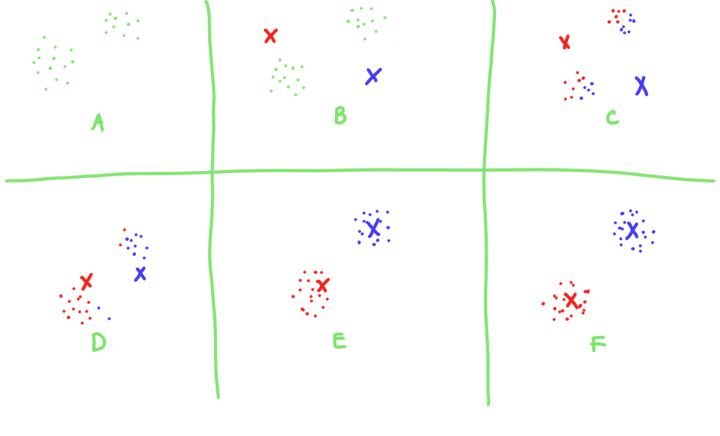

In [11]:
from IPython.display import Image
Image("base21-small-transparent.png")

Figure adapted from: http://stanford.edu/~cpiech/cs221/img/kmeansViz.png

In the code that follows, it will be convenient to use our usual "data matrix" convention, that is, each row of a data matrix $X$ is one of $m$ observations and each column (coordinate) is one of $d$ predictors. However, we will not need a dummy column of ones since we are not fitting a function.<br>
$X≡⎛⎝⎜⎜⎜x̂ T0⋮x̂ Tm⎞⎠⎟⎟⎟=(x0⋯xd−1)$.

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import matplotlib as mpl
mpl.rc("savefig", dpi=100) # Adjust for higher-resolution figures

We will use the following data set which some of you may have seen previously.

In [13]:
df = pd.read_csv('{}logreg_points_train.csv'.format(DATA_PATH))
df.head()

,x_1,x_2,label
0,-0.234443,-1.075960,1
1,0.730359,-0.918093,0
2,1.432270,-0.439449,0
3,0.026733,1.050300,0
4,1.879650,0.207743,0


In [14]:
# Helper functions from Logistic Regression Lesson
def make_scatter_plot(df, x="x_1", y="x_2", hue="label",
                      palette={0: "red", 1: "olive"},
                      size=5,
                      centers=None):
    sns.lmplot(x=x, y=y, hue=hue, data=df, palette=palette,
               fit_reg=False)
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1],
                    marker=u'*', s=500,
                    c=[palette[0], palette[1]])
    
def mark_matches(a, b, exact=False):
    """
    Given two Numpy arrays of {0, 1} labels, returns a new boolean
    array indicating at which locations the input arrays have the
    same label (i.e., the corresponding entry is True).
    
    This function can consider "inexact" matches. That is, if `exact`
    is False, then the function will assume the {0, 1} labels may be
    regarded as the same up to a swapping of the labels. This feature
    allows
    
      a == [0, 0, 1, 1, 0, 1, 1]
      b == [1, 1, 0, 0, 1, 0, 0]
      
    to be regarded as equal. (That is, use `exact=False` when you
    only care about "relative" labeling.)
    """
    assert a.shape == b.shape
    a_int = a.astype(dtype=int)
    b_int = b.astype(dtype=int)
    all_axes = tuple(range(len(a.shape)))
    assert ((a_int == 0) | (a_int == 1)).all()
    assert ((b_int == 0) | (b_int == 1)).all()
    
    exact_matches = (a_int == b_int)
    if exact:
        return exact_matches

    assert exact == False
    num_exact_matches = np.sum(exact_matches)
    if (2*num_exact_matches) >= np.prod (a.shape):
        return exact_matches
    return exact_matches == False # Invert
    
def count_matches(a, b, exact=False):
    """
    Given two sets of {0, 1} labels, returns the number of mismatches.
    
    This function can consider "inexact" matches. That is, if `exact`
    is False, then the function will assume the {0, 1} labels may be
    regarded as similar up to a swapping of the labels. This feature
    allows
    
      a == [0, 0, 1, 1, 0, 1, 1]
      b == [1, 1, 0, 0, 1, 0, 0]
      
    to be regarded as equal. (That is, use `exact=False` when you
    only care about "relative" labeling.)
    """
    matches = mark_matches(a, b, exact=exact)
    return np.sum(matches)

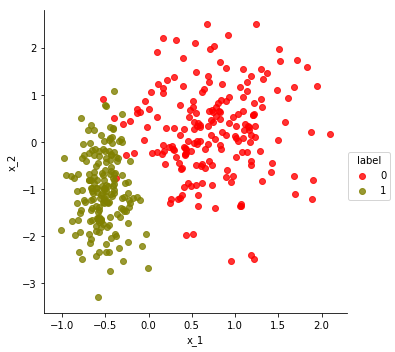

In [15]:
make_scatter_plot(df)

Let's extract the data points as a data matrix, <code>points</code>, and the labels as a vector, <code>labels</code>. Note that the k-means algorithm you will implement should __not__ reference <code>labels</code> -- that's the solution we will try to predict given only the point coordinates (<code>points</code>) and target number of clusters ($k$).

In [16]:
points = df.as_matrix(['x_1', 'x_2'])
labels = df['label'].as_matrix()
n, d = points.shape
k = 2

Note that the labels should not be used in the $k$-means algorithm. We use them here only as ground truth for later verification.

### How to start? Initializing the $k$ centers
To start the algorithm, you need an initial guess. Let's randomly choose $k$ observations from the data.<br><br>

__Exercise 1__ (2 points). Complete the following function, <code>init_centers(X, k)</code>, so that it randomly selects $k$ of the given observations to serve as centers. It should return a Numpy array of size $k$-by-$d$, where $d$ is the number of columns of $X$.

In [17]:
def init_centers(X, k):
    """
    Randomly samples k observations from X as centers.
    Returns these centers as a (k x d) numpy array.
    """
    ### BEGIN SOLUTION
    from numpy.random import choice
    samples = choice(len(X), size=k, replace=False)
    return X[samples, :]
    ### END SOLUTION

In [18]:
# Test cell: `init_centers_test`

centers_initial = init_centers(points, k)
print("Initial centers:\n", centers_initial)

assert type(centers_initial) is np.ndarray, "Your function should return a Numpy array instead of a {}".format(type(centers_initial))
assert centers_initial.shape == (k, d), "Returned centers do not have the right shape ({} x {})".format(k, d)
assert (sum(centers_initial[0, :] == points) == [1, 1]).all(), "The centers must come from the input."
assert (sum(centers_initial[1, :] == points) == [1, 1]).all(), "The centers must come from the input."

print("\n(Passed!)")

Initial centers:
 [[ 0.39765   1.19326 ]
 [-0.460407 -0.188549]]

(Passed!)


## Computing the distances
__Exercise 2__ (3 points). Implement a function that computes a distance matrix, $S=(sij)$ such that $sij=d2ij$ is the <i>squared</i> distance from point $x̂ i$ to center $μj$. It should return a Numpy matrix $S[:m, :k]$.

In [19]:
def compute_d2(X, centers):
    m = len(X)
    k = len(centers)
    
    S = np.empty((m, k))
    
    ### BEGIN SOLUTION
    for i in range(m):
        d_i = np.linalg.norm(X[i, :] - centers, ord=2, axis=1)
        S[i, :] = d_i**2
    ### END SOLUTION

    return S

In [20]:
# Test cell: `compute_d2_test`

centers_initial_testing = np.load("{}centers_initial_testing.npy".format(DATA_PATH))
compute_d2_soln = np.load("{}compute_d2_soln.npy".format(DATA_PATH))

S = compute_d2 (points, centers_initial_testing)
assert (np.linalg.norm (S - compute_d2_soln, axis=1) <= (10.0 * np.finfo(float).eps)).all ()

print("\n(Passed!)")


(Passed!)


__Exercise 3__ (2 points). Write a function that uses the (squared) distance matrix to assign a "cluster label" to each point.

That is, consider the $m×k$ squared distance matrix $S$. For each point $i$, if $s_{i,j}$ is the minimum squared distance for point $i$, then the index $j$ is $i$'s cluster label. In other words, your function should return a (column) vector $y$ of length $m$ such that<br>
$yi=argminj∈{0,…,k−1}sij$.<br>

Hint: Judicious use of Numpy's <A href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmin.html">argmin()</a> makes for a nice one-line solution.

In [21]:
def assign_cluster_labels(S):
    ### BEGIN SOLUTION
    return np.argmin(S, axis=1)
    ### END SOLUTION

# Cluster labels:     0    1
S_test1 = np.array([[0.3, 0.2],  # --> cluster 1
                    [0.1, 0.5],  # --> cluster 0
                    [0.4, 0.2]]) # --> cluster 1
y_test1 = assign_cluster_labels(S_test1)
print("You found:", y_test1)

assert (y_test1 == np.array([1, 0, 1])).all()

You found: [1 0 1]


In [22]:
# Test cell: `assign_cluster_labels_test`

S_test2 = np.load("{}assign_cluster_labels_S.npy".format(DATA_PATH))
y_test2_soln = np.load("{}assign_cluster_labels_soln.npy".format(DATA_PATH))
y_test2 = assign_cluster_labels(S_test2)
assert (y_test2 == y_test2_soln).all()

print("\n(Passed!)")


(Passed!)


__Exercise 4__ (2 points). Given a clustering (i.e., a set of points and assignment of labels), compute the center of each cluster.

In [23]:
def update_centers(X, y):
    # X[:m, :d] == m points, each of dimension d
    # y[:m] == cluster labels
    m, d = X.shape
    k = max(y) + 1
    assert m == len(y)
    assert (min(y) >= 0)
    
    centers = np.empty((k, d))
    for j in range(k):
        # Compute the new center of cluster j,
        # i.e., centers[j, :d].
        ### BEGIN SOLUTION
        centers[j, :d] = np.mean(X[y == j, :], axis=0)
        ### END SOLUTION
    return centers

In [24]:
# Test cell: `update_centers_test`

y_test3 = np.load("{}y_test3.npy".format(DATA_PATH))
centers_test3_soln = np.load("{}centers_test3_soln.npy".format(DATA_PATH))
centers_test3 = update_centers(points, y_test3)

delta_test3 = np.abs(centers_test3 - centers_test3_soln)
assert (delta_test3 <= 2.0*len(centers_test3_soln)*np.finfo(float).eps).all()

print("\n(Passed!)")


(Passed!)


__Exercise 5__ (2 points). Given the squared distances, return the within-cluster sum of squares.
In particular, your function should have the signature,

In [25]:
def WCSS(S):
        ...

where S is an array of distances as might be computed from Exercise 2.

For example, suppose S is defined as follows:

In [26]:
S = np.array([[0.3, 0.2],
                  [0.1, 0.5],
                  [0.4, 0.2]])

Then <code>WCSS(S) == 0.2 + 0.1 + 0.2 == 0.5</code>.

Hint: See <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.amin.html#numpy.amin">numpy.amin</a>.

In [27]:
def WCSS(S):
    ### BEGIN SOLUTION
    return np.sum(np.amin(S, axis=1))
    ### END SOLUTION
    
# Quick test:
print("S ==\n", S_test1)
WCSS_test1 = WCSS(S_test1)
print("\nWCSS(S) ==", WCSS(S_test1))

S ==
 [[ 0.3  0.2]
 [ 0.1  0.5]
 [ 0.4  0.2]]

WCSS(S) == 0.5


In [28]:
# Test cell: `WCSS_test`

assert np.abs(WCSS_test1 - 0.5) <= 3.0*np.finfo(float).eps, "WCSS(S_test1) should be close to 0.5, not {}".format(WCSS_test1)
print("\n(Passed!)")


(Passed!)


Lastly, here is a function to check whether the centers have "moved," given two instances of the center values. It accounts for the fact that the order of centers may have changed.

In [29]:
def has_converged(old_centers, centers):
    return set([tuple(x) for x in old_centers]) == set([tuple(x) for x in centers])

__Exercise 6__ (3 points). Put all of the preceding building blocks together to implement Lloyd's $k$-means algorithm.

In [30]:
def kmeans(X, k,
           starting_centers=None,
           max_steps=np.inf):
    if starting_centers is None:
        centers = init_centers(X, k)
    else:
        centers = starting_centers
        
    converged = False
    labels = np.zeros(len(X))
    i = 1
    while (not converged) and (i <= max_steps):
        old_centers = centers
        ### BEGIN SOLUTION
        S = compute_d2(X, centers)
        labels = assign_cluster_labels(S)
        centers = update_centers(X, labels)
        converged = has_converged(old_centers, centers)
        ### END SOLUTION
        print ("iteration", i, "WCSS = ", WCSS (S))
        i += 1
    return labels

clustering = kmeans(points, k, starting_centers=points[[0, 187], :])

iteration 1 WCSS =  549.917553549
iteration 2 WCSS =  339.800663303
iteration 3 WCSS =  300.330112922
iteration 4 WCSS =  289.807007773
iteration 5 WCSS =  286.074559106
iteration 6 WCSS =  284.190770558
iteration 7 WCSS =  283.227322499
iteration 8 WCSS =  282.456491303
iteration 9 WCSS =  281.848382253
iteration 10 WCSS =  281.572420827
iteration 11 WCSS =  281.531562799


Let's visualize the results.

329 matches out of 375 possible (~ 87.7%)


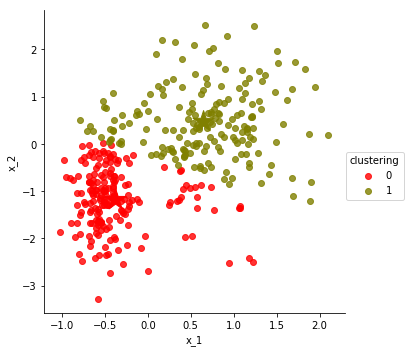

In [31]:
# Test cell: `kmeans_test`

df['clustering'] = clustering
centers = update_centers(points, clustering)
make_scatter_plot(df, hue='clustering', centers=centers)

n_matches = count_matches(df['label'], df['clustering'])
print(n_matches,
      "matches out of",
      len(df), "possible",
      "(~ {:.1f}%)".format(100.0 * n_matches / len(df)))

assert n_matches >= 320

## Built-in $k$-means
The preceding exercises walked you through how to implement $k$-means, but as you might have imagined, there are existing implementations as well! The following shows you how to use Scipy's implementation, which should yield similar results. If you are asked to use $k$-means in a future lab (or exam!), you can use this one.

In [32]:
from scipy.cluster import vq

Centers:
 [[-0.3742504  -1.17922941]
 [ 0.65580448  0.4690796 ]]

Compare with your method:
 [[-0.37382602 -1.18565619]
 [ 0.64980076  0.4667703 ]] 

Distortion (WCSS): 0.749385312802
329 matches out of 375 possible (~ 87.7%)


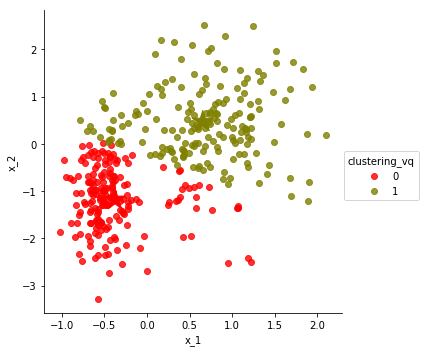

In [33]:
# `distortion` below is the similar to WCSS.
# It is called distortion in the Scipy documentation
# since clustering can be used in compression.
centers_vq, distortion_vq = vq.kmeans(points, k)

# vq return the clustering (assignment of group for each point)
# based on the centers obtained by the kmeans function.
# _ here means ignore the second return value
clustering_vq, _ = vq.vq(points, centers_vq)

print("Centers:\n", centers_vq)
print("\nCompare with your method:\n", centers, "\n")
print("Distortion (WCSS):", distortion_vq)

df['clustering_vq'] = clustering_vq
make_scatter_plot(df, hue='clustering_vq', centers=centers_vq)

n_matches_vq = count_matches(df['label'], df['clustering_vq'])
print(n_matches_vq,
      "matches out of",
      len(df), "possible",
      "(~ {:.1f}%)".format(100.0 * n_matches_vq / len(df)))

__Fin!__ That marks the end of this notebook. Don't forget to submit it!

In [34]:
from IPython.display import HTML
HTML(filename='14-main.html')